## A Bayesian Search for Hannibal's Marauding Army During the Second Punic War
##### This notebook is lifted from [this](http://www.subsubroutine.com/sub-subroutine/2014/05/18/a-bayesian-search-for-hannibals-marauding-army-during-the-second-punic-war) blog post, originally from [subsubroutine](http://www.subsubroutine.com/#blog).
Here's our (semi-fictitious) search scenario: In 217 B.C., Rome and Carthage are at war. Dido's curse still haunts the two civilizations. Carthaginian General Hannibal Barca has just annihilated a Roman army at Lake Tresimene, 180km northwest of Rome. He had already inflicted a series of crushing defeats on the Romans to the point that, after Lake Tresimene, Rome was left virtually without any field army at all. 

The great fear was that Hannibal would now march his war elephants on the city of Rome itself. In times of dire emergency, the Roman republic allowed for the temporary appointment of a dictator. Five days after Lake Tresimene, the senate appointed Quintus Fabius Maximus as dictator. The first question for him was: where is Hannibal now?

To attempt to answer this question, we're going to do a Bayesian search for Hannibal's army. Before we can start, the first thing we need to do is construct a probability map of where Hannibal could be. In Bayesian parlance, this is known as the *prior*.

In [1]:
import numpy as np, pandas as pd

import scipy
from scipy import spatial
from scipy.stats import beta

import netCDF4

import matplotlib.pyplot as mp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap, shiftgrid, cm

In [2]:
default_figsize = (17,10)
default_offset = 10000

cmap = mp.cm.get_cmap('RdYlGn')

Rome = [41.9, 12.5]
Trasimene = [43.133333, 12.1]

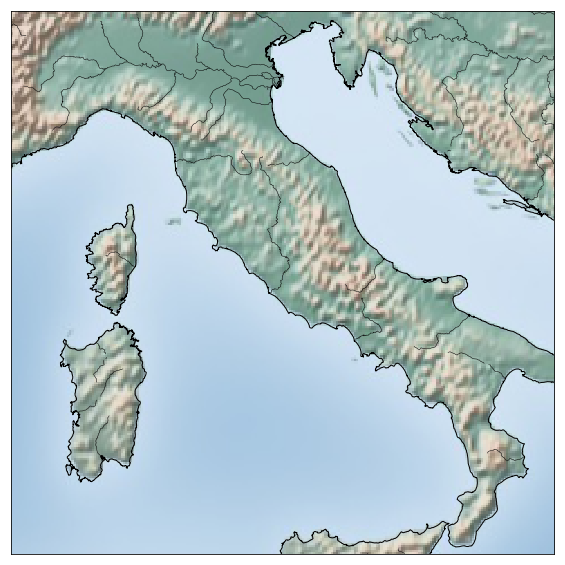

In [3]:
fig = mp.figure(figsize=default_figsize)
     
m = Basemap(width=900000,
            height=900000,
            projection='lcc',
            resolution='h',
            lat_0=Rome[0],
            lon_0=Rome[1],
            area_thresh=1000)    
 
m.shadedrelief()
m.drawcoastlines()
m.drawrivers()

Let's zoom in on the part of Italy where the action takes place:

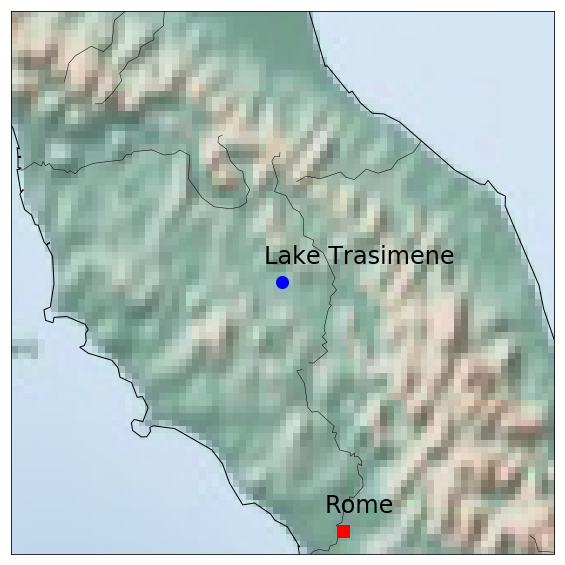

In [4]:
m = Basemap(height=300000,
            width=300000,
            projection='lcc',
            resolution='i',
            lat_0=Trasimene[0],
            lon_0=Trasimene[1],
            area_thresh=1000)    
 
Rome_xy = m(Rome[1],Rome[0])
Rome_x, Rome_y = Rome_xy[0], Rome_xy[1]
Trasimene_xy = m(Trasimene[1],Trasimene[0])
Trasimene_x, Trasimene_y = Trasimene_xy[0], Trasimene_xy[1]

def plot_italy(labels=False):
    fig = mp.figure(figsize=default_figsize)

    m.plot(Rome_x, Rome_y, 's', markersize=12, color='red')
    label = 'Rome' if labels else None
    mp.text(Rome_x - default_offset, Rome_y + default_offset, label, size=24)
     
    m.plot(Trasimene_x, Trasimene_y, 'bo', markersize=12)
    label = 'Lake Trasimene' if labels else None
    mp.text(Trasimene_x-default_offset, Trasimene_y+default_offset,label,size=24)
  
    m.shadedrelief()
    m.drawcoastlines()
    m.drawrivers()
     
plot_italy(True)

The topography is a little blurry when you zoom in on matplotlib's basemaps. The important thing is that we can see the mountains and that's material to our search. We're going to focus on this 300x300 kilometers part of Italy, with Lake Tresimene in the middle and Rome to the south. Incidentally, matplotlib's *basemap()* function returns an (x,y) grid, where x and y are measured in meters.

Now we want to calculate P(Hannibal=present) for each (x,y) km<sup>2</sup> in our search space. Where could Hannibal be? Anywhere in Italy? If we thought Hannibal could be literally anywhere in Italy with equal probability then we would have a very large search space and no idea where to start. But Fabius Maximus knows a few things that will narrow the search space:

- Hannibal can't be more than five-days' march from Lake Tresimene.
- He is more likely to have headed south than north (he came from the north).
- He is going to be on land.
- He is less likely to be found in mountainous regions, since elephants are notoriously difficult to lead uphill (prior to Hannibal's arrival, most Romans had never seen an elephant, so misinformation was rife).

![](https://images.squarespace-cdn.com/content/v1/54856bade4b0c4cdfb17e3c0/1418527392724-CQHD9NUEF56UHMIYMW5D/ke17ZwdGBToddI8pDm48kEVzom4frgg_m5QMVDXQMHJZw-zPPgdn4jUwVcJE1ZvWhcwhEtWJXoshNdA9f1qD7Xj1nVWs2aaTtWBneO2WM-u_PXS2n9gvFPdCS2Mde24P58_WUYpflYsb1GZsMAenog/Fabius+Maximus.jpg)

Our first job is to code these four beliefs into a prior probability distribution over our search space. One of the challenges of the Bayesian approach is that everything must be mathematically quantified, and sometimes this takes guesswork or approximation.

Let's start with the first two: Hannibal can't be more than five days' march from Lake Tresimene. Fabius Maximus does some mental calculations, makes allowances for war elephants... and decides that Hannibal could march his army up to 20km per day. For the full five days, let's assume that the distance he could march can be represented with a beta distribution shaped like this:

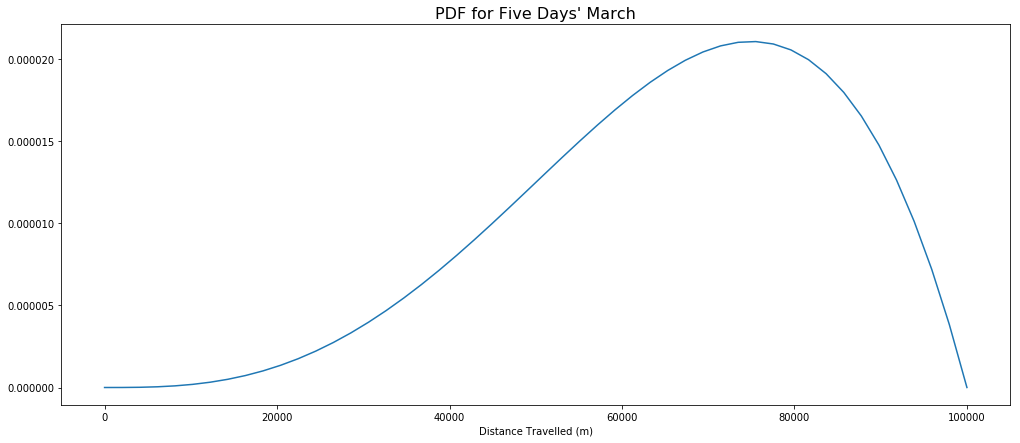

In [5]:
rv = scipy.stats.beta(4, 2, loc=0, scale=100000)
marchDist = np.linspace(0, 100000, 50)
pmarchDist = rv.pdf(marchDist)
 
fig = mp.figure(figsize=(17,7))
mp.title('PDF for Five Days\' March', size=16)
mp.xlabel('Distance Travelled (m)')
mp.plot(marchDist, pmarchDist)

Fabius Maximus has no idea which direction Hannibal went, but he expects that Hannibal is unlikely to head back north. So let's assume any direction that is south of Lake Tresimene is twice as likely as those to the north. Thus we'd therefore expect to find Hannibal in donut-shaped probability distribution centered around Lake Tresimene, with the bottom part of the donut having a higher probability than the top half:

In [6]:
# construct a 300x300 grid for our probability distribution
XX, YY = np.meshgrid(np.linspace(0, 300000, 300) , np.linspace(0, 300000, 300))

In [7]:
XYgrid = np.c_[XX.ravel(), YY.ravel()]
zdist = spatial.distance.cdist(XYgrid, [Trasimene_xy])
p_march = np.asarray(rv.pdf(zdist).reshape(XX.shape))

In [8]:
# double likelihoods for all points south of Lake Tresimene
p_southwards = map(lambda x: 2 if x[1] < Trasimene_y else 1, XYgrid)
p_southwards = np.fromiter(p_southwards, dtype=np.float32).reshape(XX.shape)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(1.1, 0.01, 'Lower\nProbability')

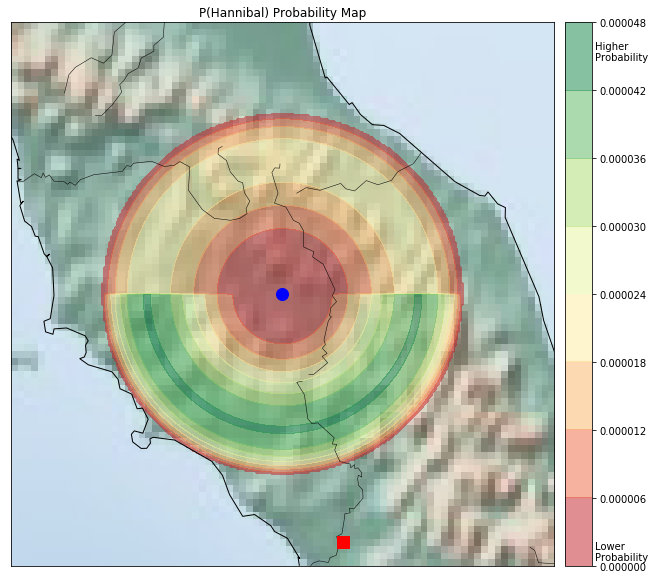

In [9]:
# combine the two beliefs into a single search space
p_prior = np.exp(np.log(p_march) + np.log(p_southwards))
 
# mask zeroes so that matplotlib colormap ignores them
p_prior_plot = p_prior.copy()
p_prior_plot[p_prior_plot==0] = np.nan
 
plot_italy()

mp.title('P(Hannibal) Probability Map')
m.contourf(XX, YY, p_prior_plot, cmap=cmap, alpha=0.5)
cbar = m.colorbar()
cbar.ax.text(1.1, 0.93,'Higher\nProbability', ha='left')
cbar.ax.text(1.1, 0.01, 'Lower\nProbability', ha='left')

Already we've cut down the search space dramatically. We can do better: let's add in beliefs three and four. Fabius Maximus knows that it would be difficult for Hannibal to lead his army into the mountains. He guesstimates that Hannibal is far less likely to be in higher altitude regions than in the plains. Using topological data we can reduce the probability of the mountainous regions of our map:

So we have defined a probability distribution across our search space. There are a few strips of dark green which correspond with the low-lying areas roughly four- to five-days' march south of Lake Tresimene. This reflects Fabius Maximus' beliefs about where Hannibal probably is.

With more beliefs we could go on developing our search space, but we'll stop there. It may have struck some readers that our definition of the search space using the Roman beliefs was somewhat haphazard. Why, for example, did we define 'higher altitude' as 250m above sea level, rather than 500m? or 100m? Often, we must resort to guesswork or arbitrariness in order to quantify our beliefs. We'll talk a bit about that at the end.

In [10]:
!wget "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/data.nc"

--2019-12-14 22:38:53--  https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/data.nc
Resolving iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)... 129.236.110.35
Connecting to iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)|129.236.110.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18689496 (18M) [application/x-netcdf]
Saving to: ‘data.nc’

data.nc             100%[===================>]  17.82M  5.73MB/s    in 3.1s    

2019-12-14 22:38:57 (5.73 MB/s) - ‘data.nc’ saved [18689496/18689496]



In [11]:
etopo_data = netCDF4.Dataset('data.nc')
print(etopo_data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    description: ETOPO5 5x5 minute land surface elevations and sea floor depths
    dimensions(sizes): Y(2160), X(4320)
    variables(dimensions): float32 Y(Y), float32 X(X), int16 elev(Y,X)
    groups: 


In [12]:
etopo_data.variables

{'Y': <class 'netCDF4._netCDF4.Variable'>
 float32 Y(Y)
     standard_name: latitude
     pointwidth: 0.08333333
     gridtype: 0
     units: degree_north
 unlimited dimensions: 
 current shape = (2160,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'X': <class 'netCDF4._netCDF4.Variable'>
 float32 X(X)
     standard_name: longitude
     pointwidth: 0.08333333
     gridtype: 1
     units: degree_east
 unlimited dimensions: 
 current shape = (4320,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'elev': <class 'netCDF4._netCDF4.Variable'>
 int16 elev(Y, X)
     long_name: elevation/bathymetry
     units: m
     colorscalename: topographycolorscale
     scale_max: 7964.0
     ncolor: 253
     CE: 7964.0
     maxncolor: 253
     scale_min: -9964.0
     CS: -9964.0
     colormap: [0 1973790 4026644 [4026644 28] 9125192 [9125192 28] [15736992 15] [11829830 15] [16711680 15] [16760576 29] [16776960 14] 65280 3329434 2330219 [9234160 3] 65535 55295 755384 [7

In [13]:
topo = etopo_data.variables['elev'][:]
lons = etopo_data.variables['X'][:]
lats = etopo_data.variables['Y'][:]

In [14]:
lats

masked_array(data=[ 90.      ,  89.916664,  89.833336, ..., -89.75    ,
                   -89.83333 , -89.916664],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [15]:
lons

masked_array(data=[0.0000000e+00, 8.3333328e-02, 1.6666666e-01, ...,
                   3.5975000e+02, 3.5983331e+02, 3.5991666e+02],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [16]:
# shift data so lons go from -180 to 180 instead of 20 to 380.
topo, lons = shiftgrid(180., topo, lons, start=False)

In [17]:
def plot_terrain():
    # limit to our region, and transform to a 300x300 grid, same as our existing probability space
    topo_data = m.transform_scalar(topo, lons, lats, 300, 300)

    # define function that codes regions with relative likelihoods
    def topo_probs(x):
        if x < 0:         
            return 0.0   # below sea level = no chance
        elif x <= 250:
            return 0.6   # not mountains = most likely
        else:
            return 0.3   # mountains = half as likely

    # convert topographical data into relative likelihoods
    probs_vec = np.vectorize(topo_probs)

    # combine existing probability map with topographical probabilities
    p_prior = np.exp(np.log(p_prior) + np.log(probs_vec(topo_data)))

    # mask zeroes so that matplotlib colormap ignores them
    p_prior_plot = p_prior.copy()
    p_prior_plot[p_prior_plot==0] = np.nan

    plot_italy()

    mp.title('P(Hannibal) Probability Map')
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.text(1.1, 0.93,'Higher\nProbability', ha='left')
    cbar.ax.text(1.1, 0.01, 'Lower\nProbability', ha='left')
    
    m.contourf(XX, YY, p_prior_plot, cmap=my_cmap, alpha=0.5)

So we have defined a probability distribution across our search space. There are a few strips of dark green which correspond with the low-lying areas roughly four to five-days' march south of Lake Tresimene. This reflects Fabius Maximus' beliefs about where Hannibal probably is.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Mommsen_p265.jpg/220px-Mommsen_p265.jpg)

With more beliefs we could go on developing our search space, but we'll stop there. It may have struck some readers that our definition of the search space using the Roman beliefs was somewhat haphazard. Why, for example, did we define 'higher altitude' as 250m above sea level, rather than 500m? or 100m? Often, we must resort to guesswork or arbitrariness in order to quantify our beliefs. We'll talk a bit about that at the end.

### Bayesian Search
The process of Bayesian search works like this:

First, we select a spot from our probability map - ideally, select the spot which has the highest probability of containing the target. Search it. If you find the target, stop. If you don't, then update your probability map to show that you've looked in that spot.

This is common sense. The beauty of the Bayesian method is that it a mathematical framework for commonsense, deductive reasoning.

If we search an area for Hannibal and he isn't there, then the math for updating our probability map looks like this:

**P(Hannibal = present | chance of spotting him) ∝ P(chance of spotting him | Hannibal = present) * P(Hannibal = present)**

We do that for the entire (x,y) grid. (Incidentally, the intuitive approach of treating the search space as a grid of discrete points, rather than a continuous space, makes the application of Bayes much simpler.) In practice, to avoid potential problems that can be caused by multiplying small numbers together, we use logs to do the calculation:

**log[P(Hannibal = present | chance of spotting him)] ∝ log[P(chance of spotting him | Hannibal = present)] + log[P(Hannibal = present)]**

We've already defined our map of P(Hannibal = present). Let's address the chance of spotting him:

Assume that a Roman scouting party has a 99% chance of spotting Hannibal if Hannibal is in the same (x,y) km<sup>2</sup> spot. (Why not 100%? Well, let's just say that those Roman scouts aren't all reliable. Sometimes they get lost and go to the wrong spot, and sometimes they instead undertake a search of the local publican's house, etc.)
A scouting party will search around their target area, and they can (of course) see farther than 1km. But their visibility rapidly diminishes, and their chances of spotting Hannibal get smaller as the distance from the target search area grows. We assume that their chances of spotting Hannibal decrease by 5% with each km.
This all makes more sense when you see it done, so let's try it.

Where should Quintus Fabius Maximus search first? We have a few places on the map with equally high probability. Fabius Maximus is particularly worried that Hannibal might be headed towards Rome, so he sends a scout out to look at that high-probablity spot on the Tiber river here:

Text(155000, 90000, 'Scout')

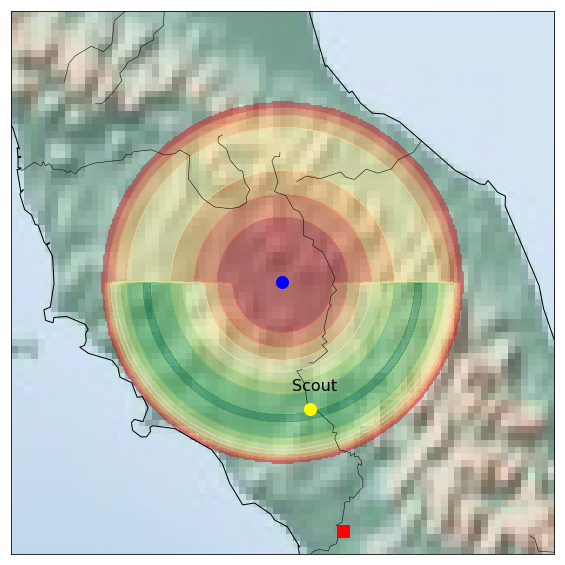

In [18]:
plot_italy()

m.contourf(XX, YY, p_prior_plot, cmap=cmap, alpha=0.5)
 
scout1 = [165000, 80000]

m.plot(scout1[0], scout1[1], 'bo', markersize=12, c='yellow')

mp.text(scout1[0] - default_offset, scout1[1] + default_offset, 'Scout', size=16)

On arriving, the scouting party looks around. Let's plot their field of vision or, in terms of our likelihood formula, P(chance of spotting him | Hannibal=present):

Text(0.5, 1.0, "P(detection | Hannibal)  Map of Scout's Vision")

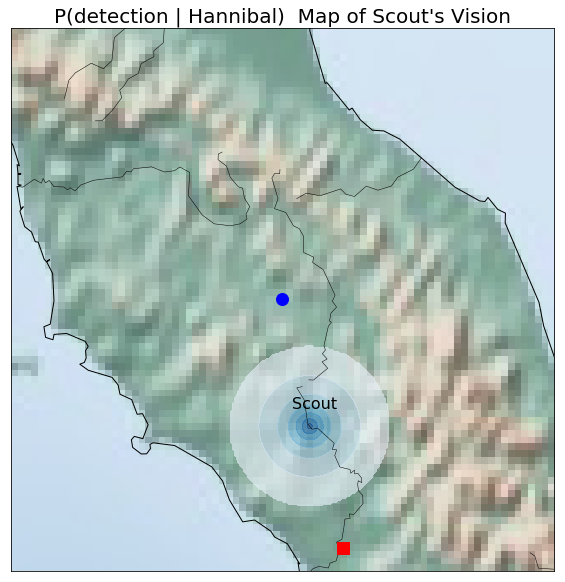

In [19]:
# plot scout field of vision
XYgrid = np.c_[XX.ravel(), YY.ravel()]
zdist = spatial.distance.cdist(XYgrid, [scout1])
 
# calculate probability of scout spotting Hannibal, were he present, at each grid point
p_search = (0.99 * 0.98**(zdist/300)).reshape(XX.shape)
p_search = np.round(p_search, 3) # round off at 3 decimal places - beyond that the chance of spotting is so small...
 
# mask low probabilities so that matplotlib colourmap ignores them
p_search_plot = p_search.copy()
p_search_plot[p_search_plot<0.05] = np.nan
 
plot_italy()
m.contourf(XX,YY, p_search_plot, cmap='Blues', alpha=0.6)
mp.text(scout1[0] - default_offset, scout1[1] + default_offset, 'Scout', size=16)
mp.title('P(detection | Hannibal)  Map of Scout\'s Vision', size=20)

Darker shades of blue mean the scout is very likely to spot Hannibal (if he were there). Lighter colours, which are distant from the scout, mean that the scout could spot Hannibal there, but it's a long way away and it's less unlikely. Those distant spots we would be less confident about crossing off our map, as we have less confidence that they've been comprehensively searched.

This information about the likelihood of spotting is important. When we update our probability map, we want it to reflect that areas near the scout have been searched very well, and areas distant have been searched poorly.

Let's do that:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(1.1, 0.01, 'Lower\nProbability')

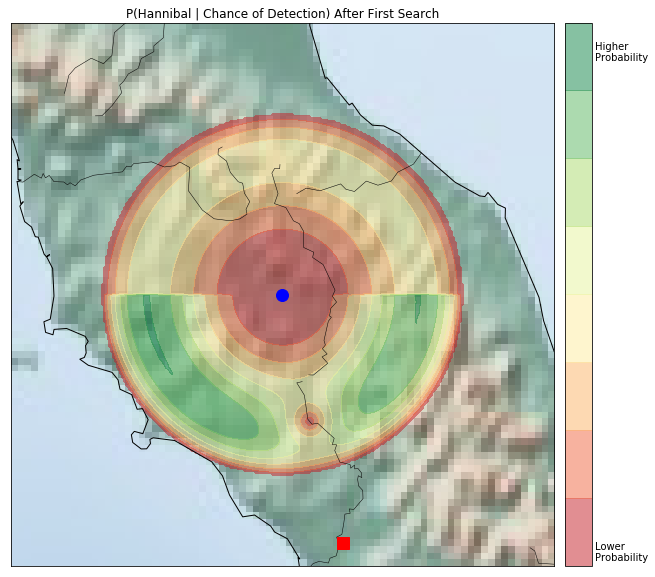

In [20]:
# use Bayes to update prior to posterior
p_posterior = np.exp(np.log(p_prior) + np.log((1 - p_search)))

# mask zeroes so that matplotlib colormap ignores them
p_posterior_plot = p_posterior.copy()
p_posterior_plot[p_posterior_plot==0] = np.nan

plot_italy()

mp.title('P(Hannibal | Chance of Detection) After First Search')

m.contourf(XX, YY, p_posterior_plot, cmap=cmap, alpha=0.5)

cbar = m.colorbar()
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(1.1, 0.93, 'Higher\nProbability', ha='left')
cbar.ax.text(1.1, 0.01, 'Lower\nProbability', ha='left')

The spot on the river between Rome & Lake Tresimene has become red: the scout searched here and didn't find Hannibal, so it is unlikely (though not impossible) that he could be here. The area around that spot takes on receding shades of orange, yellow, and then green, reflecting the knowledge that scout's field of vision diminishes with distance.

The exact site of the scout's search now has a very low probability of concealing Hannibal though it is not zero. Nevertheless, we wouldn't search there again straight away, because there's a much higher probability of finding Hannibal in other places we haven't searched. Obviously, we should choose one of those places as our next candidate...

And that's how Bayesian search works. You just repeat that process, over and over, until you find the target. Because you always search in descending order of probability of finding Hannibal, you should find your target as quickly as possible.

Let's do one another round, this time with three scouts:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


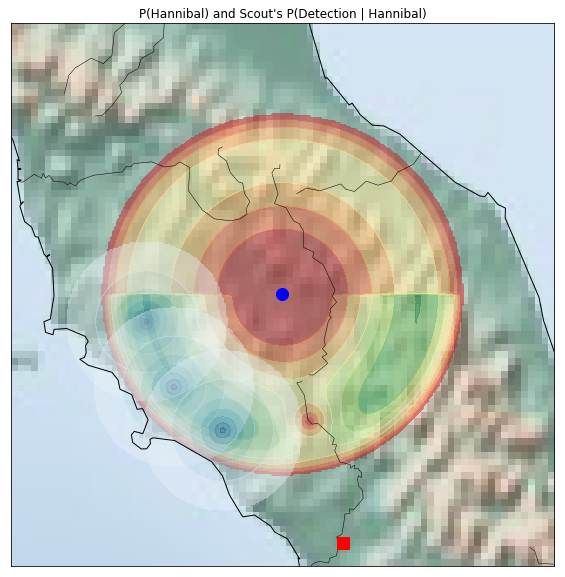

In [21]:
plot_italy()

m.contourf(XX, YY, p_posterior_plot, cmap=cmap, alpha=0.5)
mp.title('P(Hannibal) and Scout\'s P(Detection | Hannibal)')
 
scouts = [[300*250, 300*450], [300*300, 330*300], [390*300, 250*300]]
 
for scout in scouts:
    zdist = spatial.distance.cdist(XYgrid, [scout])
     
    # calculate probability of scout spotting Hannibal, were he present, at each grid point
    p_search = (0.99 * 0.98**(zdist/300)).reshape(XX.shape)
    p_search = np.round(p_search, 3)   
     
    # update posterior
    p_prior = p_posterior.copy()
    p_posterior = np.exp(np.log(p_prior) + np.log((1 - p_search)))
     
    # plot field of vision
    p_search_plot = p_search.copy()
    p_search_plot[p_search_plot < 0.05] = np.nan
     
    m.contourf(XX,YY, p_search_plot, cmap='Blues', alpha=0.4)

Text(1.1, 0.01, 'Lower\nProbability')

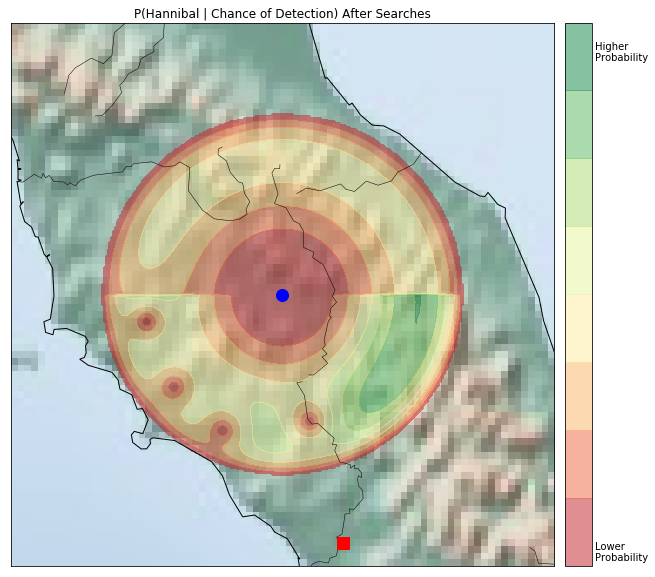

In [22]:
p_posterior_plot = p_posterior.copy()
p_posterior_plot[p_posterior_plot==0] = np.nan
 
plot_italy()

m.contourf(XX, YY, p_posterior_plot, cmap=cmap, alpha=0.5)

mp.title('P(Hannibal | Chance of Detection) After Searches')
cbar = m.colorbar()
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(1.1, 0.93, 'Higher\nProbability', ha='left')
cbar.ax.text(1.1, 0.01, 'Lower\nProbability', ha='left')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


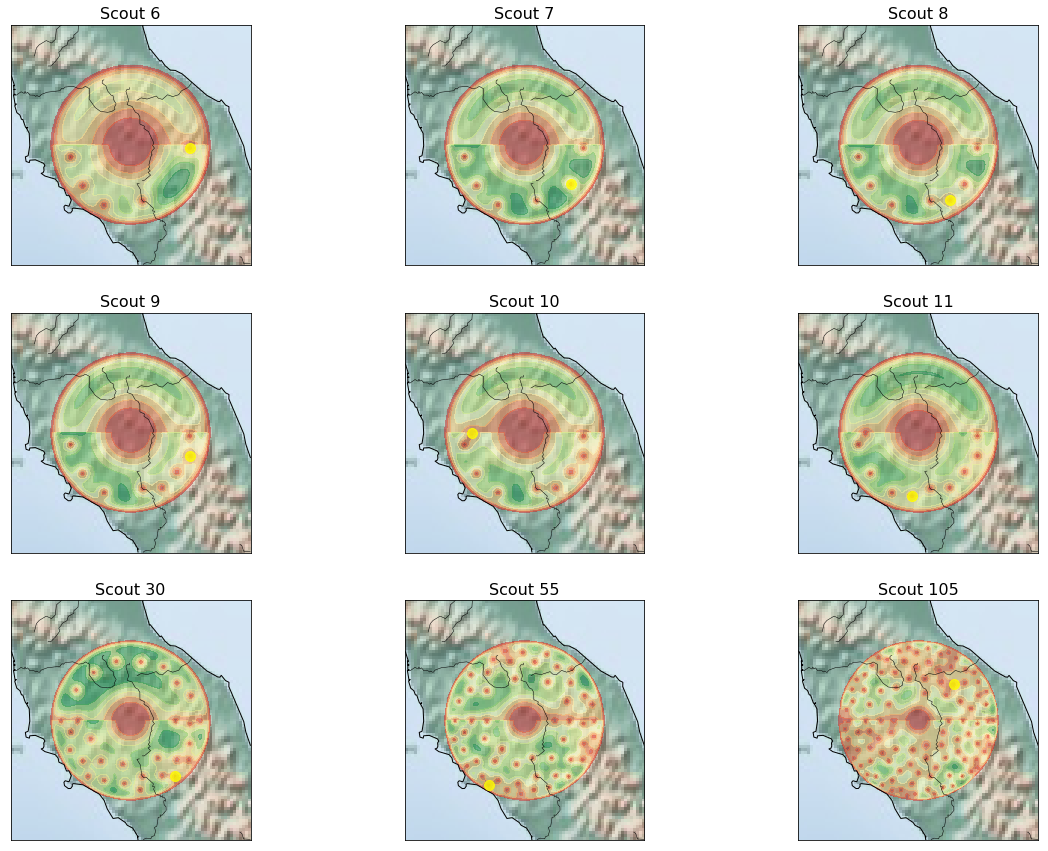

In [23]:
# create 2x3 grid
fig = mp.figure(figsize=(20,15))
 
grid_size = (3,3)
plot_spots = [(i,j) for i in range(grid_size[0]) for j in range(grid_size[1])]
 
p_post = p_posterior.copy()

scouts = [1, 2, 3, 4, 5, 6, 25, 50, 100]
counter = 0

for i in scouts:
    while counter < i:
        # set prior
        p_prior = p_post.copy()
         
        # identify highest probability spot 
        maxix = np.argmax(p_prior)
        scout = np.multiply(1000, np.unravel_index(maxix, p_prior.shape, order='F'))
     
        # calculate scout vision - i.e. P(chance of spotting | Hannibal = present)
        zdist = spatial.distance.cdist(XYgrid, [scout])
     
        # calculate probability of scout spotting Hannibal, were he present, at each grid point
        p_search = (0.99 * 0.98**(zdist/300)).reshape(XX.shape)
        p_search = np.round(p_search, 3)   
     
        # update posterior
        p_post = np.exp(np.log(p_prior) + np.log((1 - p_search)))
         
        counter = counter + 1
     
    ax = mp.subplot2grid(grid_size, plot_spots[scouts.index(i)])

    m.shadedrelief()
    m.drawcoastlines()
    m.drawrivers()
     
    ax.plot(scout[0], scout[1], 'bo', markersize=10, c='yellow', alpha=0.8)
 
    p_posterior_plot = p_post.copy()
    p_posterior_plot[p_posterior_plot==0] = np.nan
     
    ax.contourf(XX, YY, p_posterior_plot, cmap=cmap, alpha=0.5) 
    ax.set_title('Scout ' + str(i+5), size=16)

Of course, the Romans never did get Hannibal in Italy. After Lake Tresimene they stopped trying. Fabius Maximus' strategy was to avoid Hannibal's much larger army and instead harass his supply lines. After eleven years of Hannibal marauding around Italy, the Romans had the idea to ignore him and attack Carthage instead. It worked: Hannibal was immediately recalled to defend his homeland.

Let's close by recognizing the biggest shortcoming of the Bayesian approach. Bayes is a mathematical formulation for reasoning, which means it can only function if we can quantify everything. Any hypothesis or belief or evidence that we want to compute with Bayes must take a probabilistic form. This is a problem when we have information that isn't easily quantified. For example, we assumed that when a scout searches an area, he has a 99% chance of spotting Hannibal. Why 99% and not 98% or 53%? Well, it was 99% because that was my best guess. In order to get everything quantified so we can use Bayes, we may be forced to make a number of approximations.

An obvious place where our estimates could be hugely problematic is in setting out the initial prior search space. If we choose our search space poorly by, for example, making the region too small, then the Bayesian search may go forever without finding the object. In our example, Quintus Fabius Maximus decided that Hannibal could not march more than 100km in five days. But, if Hannibal had marched more than that, then he would already have left the search space. This brings to mind Sherlock Holmes' dictum, “once you eliminate the impossible, whatever remains, no matter how improbable, must be the truth.” In Bayesian searching, anything that we define as impossible in our prior - by which I mean we set the probability to 0 - will never become possible as it will never enter the search space.